In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import cv2
import pickle
import collections
import seaborn as sns
import glob
from matplotlib.pyplot import *
from utility import *
#from pathos.multiprocessing import ProcessingPool, ThreadingPool
from os.path import basename, splitext

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def separate_outliers(x, t=1.5):
    """ Finds outliers in a 1D array/list by finding all values that fall
    within `t` distance to the left and right of first and third quartiles 
    respectively.
    input: 1D array and the coefficient of IQR we want to use to detect
    outliers."""
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    m = np.median(x)
    iqr = q3-q1
    outliers = (x < q1-t*iqr) | (x>q3+t*iqr)
    return x[~outliers], x[outliers]

In [4]:
def get_global_stats(df):
    """Input: """
    #average neighborhood size
    x, xp = separate_outliers(df.end-df.beg)
    x, xp = separate_outliers(x)
    boxplot(x)
def q1(x):
    return np.percentile(x, 25)
def q3(x):
    return np.percentile(x, 75)
def p95(x):
    return np.percentile(x, 95)
def p5(x):
    return np.percentile(x, 5)

In [5]:
def get_all_circles(rotated):
    """
    params:
    rotated: a 2d image. for each verticl provile in rotated, all circles are extracted."""
    allCircles = []
    for i, profile in enumerate(rotated):
        _kernel_size = int(np.percentile(get_cut_points(profile, profile.mean()), 25))
        #print("kernel size param %r"%_kernel_size)
        x, y, der1, der2, local_minima_2d, circles = extract_circles(np.arange(len(profile)), 
                                                             profile,
                                                             kernel_size_param=_kernel_size,
                                                             same_scale=True, verbose=False)       
        if i%300==0:
            draw_circles(x, y, circles)
            show()
        allCircles.append(circles)
    return allCircles

In [6]:
# reminded: Circle = collections.namedtuple('Circle', 'beg, end, index, h, cx, cy, r, x_mean,  x_std, y_mean, y_std')
columns = ['profile'] + list(Circle._fields)
functions = set() # keeps track of all global features
circle_functions = set() # keeps track of all functions 

def feature(fun): # registers all features
    functions.add(fun.__name__)
    return fun

def circle_feature(fun): # registers a circle (local) feature
    circle_functions.add(fun.__name__)
    return feature(fun)

def log(s):
    print("[*] %s"%s)
    
def p(n):
    """returns a functiohn that given an array x, will return its nth percentile."""
    def pp(x):
        return np.percentile(x, n)
    return pp

#profile, beg, end, index, h, cx, cy, r =  'profile beg end index h cx cy r'.split()
#stats = df[[profile, r]].groupby(profile).aggregate(['mean', 'median', 'std', p(5)])
#smalles_5percent = df.apply(lambda x: x.r < stats.r.pp.loc[x.profile], axis=1)

class Features:
    statistics = None
    circles = None
    def __init__(self, x):
        log('Starting...')
        # self.x is a 2d masked image with values below 3 std of the mean masked off.
        self.x = np.ma.array(x, mask=x<x.mean(axis=1, keepdims=True)-3*x.std(axis=1, keepdims=True))
        # the following line adaptively finds kernel size for each profile in the image
        self.kernel_sizes = [int(np.percentile(get_cut_points(profile, profile.mean()), 25)) 
                             for profile in self.x]
        log('Kernel sizes extracted')
        self.local_minima = [get_local_minima_2d(profile, kernel_size, mn=-1)
                             for profile, kernel_size in zip(self.x, self.kernel_sizes)]
        log('Local minima extracted')
        self.local_maxima = [get_local_minima_2d(-profile, kernel_size) 
                             for profile, kernel_size in zip(self.x, self.kernel_sizes)]
        log('Local maxima extracted')
 
    @feature
    def ra(self):
        """extracts ra features"""
        return np.mean(np.abs(self.x-np.mean(self.x, axis=1, keepdims=True)), axis=1)

    @feature
    def rq(self):
        """extracts rq features"""
        return np.sqrt(np.mean((self.x-np.mean(self.x, axis=1, keepdims=True))**2, axis=1))


    @feature
    def rv(self):
        """extracts rv features"""
        return np.max(self.x-np.mean(self.x, axis=1, keepdims=True), axis=1)

    @feature
    def rz(self):
        """extracts rz features"""
        return np.max(np.mean(self.x, axis=1, keepdims=True)-self.x, axis=1)

    @feature
    def r10_iso(self):
        """extracts r10_iso features"""
        return np.array([np.mean(np.sort(self.x[n][self.local_maxima[n]])[:10] ) for n in range(len(self.x))]) - \
            np.array([np.mean(np.sort(self.x[n][self.local_minima[n]])[-10:]) for n in range(len(self.x))])
    
    def get_all_circles(self):
        """
        params:
        rotated: a 2d image. for each verticl provile in rotated, all circles are extracted.
        it uses self.x, self.kernel_sizes and sets the results to self.circles"""
        allCircles = []
        for i, profile in enumerate(self.x):
            x, y, der1, der2, local_minima_2d, circles = extract_circles(np.arange(len(profile)), 
                                                                 profile,
                                                                 kernel_size_param=self.kernel_sizes[i],
                                                                 same_scale=True, verbose=False)       
            if i%500==0:
                log("Finished extracting circles from profile %5d/%5d"%(i, len(self.x)))
            allCircles.append(circles)
        self.circles = pd.DataFrame(((i, *circle) for i, circles in enumerate(allCircles) for circle in circles), columns=columns)   
        return self
    
    @circle_feature
    def rho(self):
        """extracts r10_iso features"""
        if self.circles is None:
            self.get_all_circles()
        return self.circles[[profile, r]].groupby(profile).aggregate('mean')
    
    @circle_feature
    def rho95(self):
        if self.circles is None:
            self.get_all_circles()       
        return self.circles[df.apply(lambda x: x.r < stats.r.pp.loc[x.profile], axis=1)][[profile, r]].groupby(profile).aggregate('mean')   
       
    def run_all_tests(self):
        if self.statistics is None:
            self.statistics = pd.DataFrame({name: getattr(self, name)() for name in functions})
        return self.statistics

In [7]:
def random_sub_image(img, ratio=.5):
    w, h = img.shape
    ww, hh = int(ratio*w), int(ratio*h)
    x, y = np.random.randint(max(1,w-ww)), np.random.randint(max(1,h-hh))
    return img[x:x+ww, y:y+hh]

def random_sub_length_image(img, ratio=.5):
    w, h = img.shape
    ww, hh = int(w), int(ratio*h)
    x, y = 0, np.random.randint(max(1,h-hh))
    #print(x, y)
    return img[:, y:y+hh]

def random_sub_width_image(img, ratio=.5):
    w, h = img.shape
    ww, hh = int(w*h), int(ratio)
    x, y = np.random.randint(max(1,w-ww)), 0
    return img[x:x+ww, :]

In [8]:
images_mapper = {
          'Normal': lambda x:x, 
          '50% area': lambda x: random_sub_image(x), 
          '50% area rotate': lambda x: align_image(random_sub_image(x)),
          '50% area tilt': lambda x: adjust_tilt(random_sub_image(x)),
          '25% area': lambda x: random_sub_image(x, .25),
          '50% length': lambda x: random_sub_length_image(x),
          '50% length rotate': lambda x: align_image(random_sub_length_image(x)),
          '50% length tilt': lambda x: adjust_tilt(random_sub_length_image(x)),
          '50% width': lambda x: random_sub_width_image(x),
          '50% width tilt': lambda x: adjust_tilt(random_sub_width_image(x)),
          'Rotated': lambda x: align_image(x),
          'Tilted': lambda x: adjust_tilt(x),
          'Tilted & Rotated': lambda x: adjust_tilt(align_image(x))
}

In [10]:
def foo(args):
    (k, f), x = args
    return (k, f(x))
def get_all_stats(file_name):
    with open(file_name, 'rb') as f:
        img = pickle.load(f)
    # step 0: rescale image
    rescaled_image = rescale_image(img, image_info[splitext(basename(file_names[0]))[0]])
    images = dict(map(foo, zip(images_mapper.items(), [rescaled_image]*len(images_mapper))))
    with ProcessingPool(len(images)) as pool:
        images_features = pool.map(Features, images.values())
    with ProcessingPool(len(images)) as pool:
        stats = pool.map(lambda x: x.run_all_tests(), images_features)   
    return stats

# First sets of Data

In [11]:
file_names = glob.glob('dataset/*3d.np')
#with ThreadingPool(5) as t:
#    stats_list = t.map(get_all_stats, file_names)

In [12]:
#stats = {splitext(basename(file_name))[0]: stat for file_name, stat in zip(file_names, stats_list)}

In [13]:
with open('statistics.pkl', 'rb') as f:
    stats = pickle.load(f)

In [14]:
stats

{'v02_T2_R_3d': [             ra         rq          rv         rz  r10_iso
  0     10.789794  19.492875   83.909502   5.924985      NaN
  1     20.194465  29.498148  103.334061  11.879097      NaN
  2     20.364259  29.628519  103.580823  11.978976      NaN
  3     20.452838  29.671001  103.370912  12.031081      NaN
  4     20.446311  29.641423  103.203708  12.027242      NaN
  ...         ...        ...         ...        ...      ...
  7403  28.579541  38.578926  162.790502  19.592921      NaN
  7404  26.175354  37.310504  164.394801  17.925191      NaN
  7405  24.652208  37.203940  166.654610  15.607932      NaN
  7406   0.000000   0.000000    0.000000   0.000000      NaN
  7407   0.000000   0.000000    0.000000   0.000000      NaN
  
  [7408 rows x 5 columns],
               ra         rq         rv         rz    r10_iso
  0     17.238009  22.502396  73.196678  60.137299  70.539587
  1     17.313378  22.548510  72.797982  59.867370  70.755908
  2     17.310134  22.505563  72.4352

In [15]:
name_dict = {'ra':"$R_a$", 'rq':"$R_q$", 'rv':"$R_v$", 'rz':"$R_z$", 'r10_iso':"$R_{10(ISO)}$"}
names = images_mapper.keys() - set('50% area rotate; 50% area tilt; 50% length tilt; 50% width tilt; 50% length rotate; 50% length tilt'.split('; '))
statistics = ['mean', '50%', '75%']
data = pd.DataFrame(
    [(file_name, name_dict[column], name, statistic, stat[i].describe().loc[statistic][column])
     for file_name, stat in stats.items()
     for i,name in enumerate(names) 
     for column in stat[0].columns
     for statistic in statistics],
    columns=["File Name", 'Measure', 'Variation', 'Statistics', 'Statistic Value($\mu m$)'])

In [16]:
data

,File Name,Measure,Variation,Statistics,Statistic Value($\mu m$)
0,v02_T2_R_3d,$R_a$,50% length,mean,18.102017
1,v02_T2_R_3d,$R_a$,50% length,50%,17.573910
2,v02_T2_R_3d,$R_a$,50% length,75%,19.076094
3,v02_T2_R_3d,$R_q$,50% length,mean,22.413193
4,v02_T2_R_3d,$R_q$,50% length,50%,21.832290
...,...,...,...,...,...
2875,v02_T1_L_3d,$R_z$,50% area,50%,56.095249
2876,v02_T1_L_3d,$R_z$,50% area,75%,64.103618
2877,v02_T1_L_3d,$R_{10(ISO)}$,50% area,mean,70.358315
2878,v02_T1_L_3d,$R_{10(ISO)}$,50% area,50%,69.902152


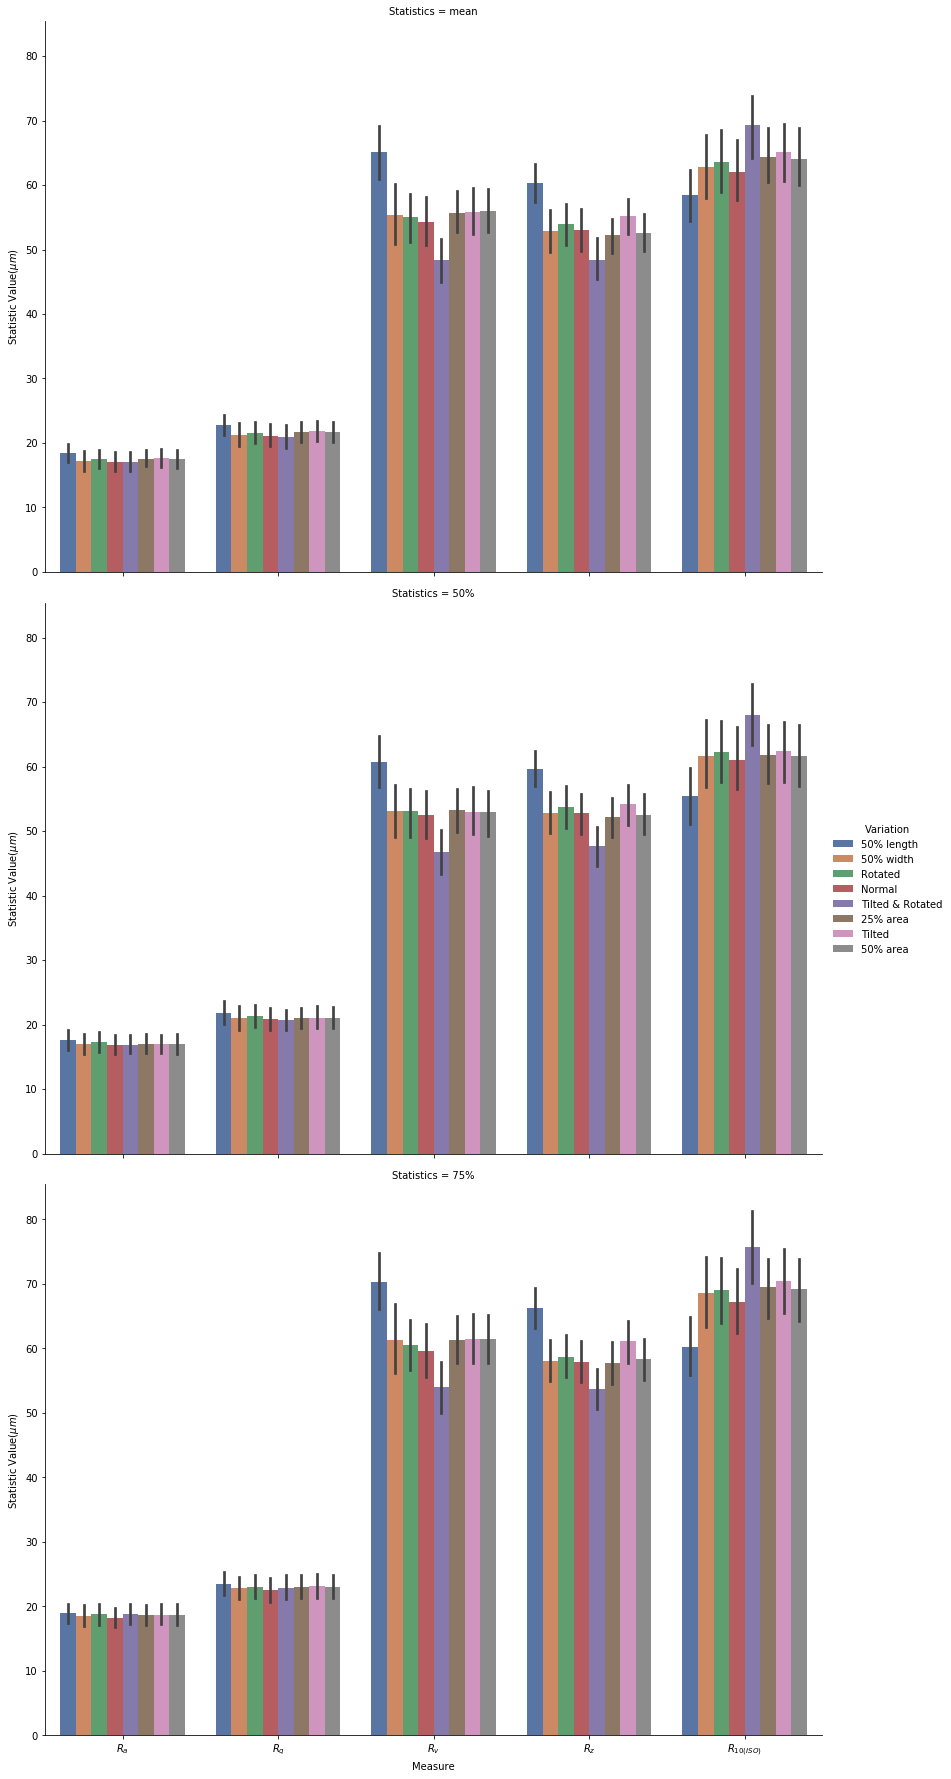

In [17]:
sns.set_palette("deep")
ax = sns.catplot(data=data, kind='bar',  height=8.27, aspect=11.7/8.27, x='Measure', y='Statistic Value($\mu m$)', hue='Variation', row='Statistics')
#savefig('global_measure_comparison.svg')

In [18]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, plot_title="", cbarlabel="", color_bar=True, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = None
    if color_bar:
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title(plot_title)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


In [19]:
from scipy.stats import ttest_ind

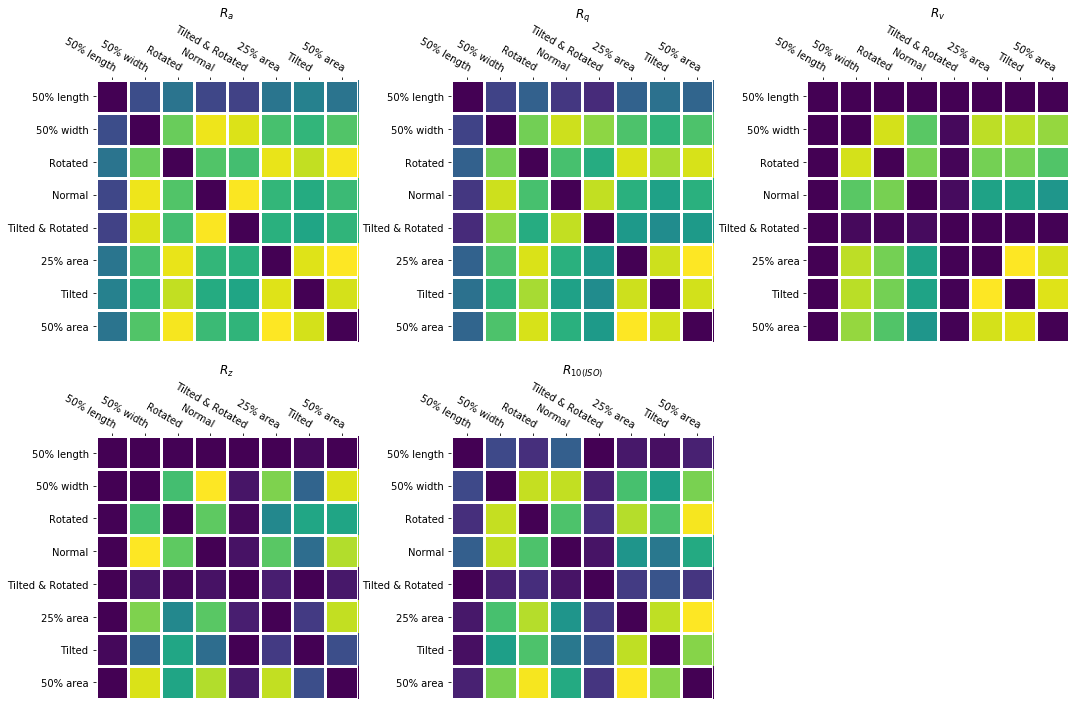

In [32]:
rcParams['figure.figsize'] = 15, 15
ncols = 3
nrows = int(np.round(len(name_dict)/ncols+.99))
for index, (feature, feature_neat) in enumerate(name_dict.items(), 1):
    #ax = subplot2grid((nrows, ncols), (index//ncols, index%ncols))
    ax = subplot(nrows, ncols, index)
    d = data[(data['Statistics'] == 'mean')&(data['Measure']==name_dict[feature])]
    unique_variations = data['Variation'].unique()
    pvalues = -2*np.zeros((len(unique_variations),)*2)
    for i, v1 in enumerate(unique_variations):
        d1 = d[(d['Variation'] == v1)][['Statistic Value($\mu m$)']]
        for j, v2 in enumerate(unique_variations):
            if i <= j:
                continue
            d2 = d[(d['Variation'] == v2)][['Statistic Value($\mu m$)']]
            pvalues[j, i] = pvalues[i,j]=(ttest_ind(d1, d2).pvalue[0])*1
    im, cbar = heatmap(pvalues, unique_variations, unique_variations, ax=ax, color_bar=False,
                       plot_title=feature_neat)
tight_layout() # Or equivalently,  "plt.tight_layout()"
savefig('hypthesis_test_variation_vs_variation.svg')

In [10]:
images_mapper = {
          '25% area': lambda x: random_sub_image(x, .25),
                }

In [69]:
def get_all_circles(file_name):
    try:
        with open(file_name, 'rb') as f:
            img = pickle.load(f)
        rescaled_image = rescale_image(img, image_info[splitext(basename(file_names[0]))[0]])
        images = dict(map(foo, zip(images_mapper.items(), [rescaled_image]*len(images_mapper))))
        #with ProcessingPool(len(images)) as pool:
        #    images_features = pool.map(Features, images.values())
        images_features = list(map(Features, images.values()))
        #with ProcessingPool(len(images)) as pool:
        #    circles = pool.map(lambda x: x.get_all_circles(), images_features)   
        circles = list(map(lambda x: x.get_all_circles(), images_features)   )
        with open(file_name+'.mardas', 'wb') as f:
            pickle.dump(circles, f)
        return True
    except Exception as e:
        return e

In [70]:
#with ThreadingPool(5) as t:
with ProcessingPool(2) as t:
    circle_stats_list = t.amap(get_all_circles, file_names[:2])

In [111]:
circle_stats_list.ready()

False

In [56]:
mardas_features = circle_stats_list.get()

In [66]:
with open('dataset/v02_T2_R_3d.np.mardas', 'rb') as f:
    df = pickle.load(f)

# Get new datasets

In [25]:
def get_file_basename(file_name):
    return splitext(basename(file_name))[0]
files = glob.glob('/nfs_shares/bzr0014_home/additive_data/*pd')
data_names = [get_file_basename(file_name) for file_name in files]

In [46]:
images_mapper = {
#          'Normal': lambda x:x, 
#          '50% area': lambda x: random_sub_image(x), 
#          '50% area rotate': lambda x: align_image(random_sub_image(x)),
#          '50% area tilt': lambda x: adjust_tilt(random_sub_image(x)),
#          '25% area': lambda x: random_sub_image(x, .25),
#          '50% length': lambda x: random_sub_length_image(x),
#          '50% length rotate': lambda x: align_image(random_sub_length_image(x)),
#          '50% length tilt': lambda x: adjust_tilt(random_sub_length_image(x)),
#          '50% width': lambda x: random_sub_width_image(x),
#          '50% width tilt': lambda x: adjust_tilt(random_sub_width_image(x)),
#          'Rotated': lambda x: align_image(x),
#          'Tilted': lambda x: adjust_tilt(x),
          'Tilted & Rotated': lambda x: adjust_tilt(align_image(x))
}

In [47]:
new_image_info ={data: ImageInfo(max_height=7500, max_width=7500, max_peak=170) for data in files}

In [10]:
def foo(args):
    (k, f), x = args
    return (k, f(x))
def get_all_stats(file_name):
    img = pickle.load(f)
    # step 0: rescale image
    rescaled_image = rescale_image(img, new_image_info[file_name])
    images = dict(map(foo, zip(images_mapper.items(), [rescaled_image]*len(images_mapper))))
    with ProcessingPool(len(images)) as pool:
        images_features = pool.map(Features, images.values())
    with ProcessingPool(len(images)) as pool:
        stats = pool.map(lambda x: x.run_all_tests(), images_features)   
    return stats

In [27]:
from dask import bag

In [37]:
file_names = bag.from_sequence(files)

In [38]:
import joblib
a = file_names.map(joblib.load)#.map(lambda x: rescale_image(x, new_image_info))

In [43]:
b = bag.zip(file_names, a).map(lambda x: rescale_image(x[1], new_image_info[x[0]]))

In [44]:
_ = b.take(1)

scales = 0.469513, 0.417385


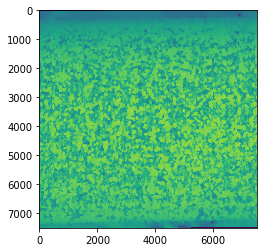

In [45]:
import matplotlib.pyplot as plt
plt.imshow(_[0])